In [11]:
from sys import platform as sys_pf
# if sys_pf == 'darwin':
#     import matplotlib
#     matplotlib.use("TkAgg")
# ! pip install simpleitk
%matplotlib inline  
import os
import numpy as np
# import nibabel as nib
from matplotlib import pyplot as plt
import matplotlib
import SimpleITK as sitk
from scipy import ndimage
import random
import math

folder = 'data/'

(176, 256, 256)
(256, 256, 176)


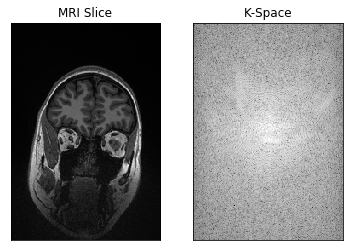

In [3]:
for item in os.listdir(folder):
    if item.endswith(".nii"):
        reader = sitk.ImageFileReader()
        reader.SetImageIO("NiftiImageIO")
        reader.SetFileName(folder + item)
        image = reader.Execute()

        # img1 = sitk.ReadImage(folder + item)  # alternative way to pull in image

        # convert image into np array & perform fft
        img = sitk.GetArrayFromImage(image)
        print(img.shape)
        
        # Transpose the image so the first axis is Anterior-Posterior
        img = np.transpose(img, (2,1,0))
        print(img.shape)
        orig_slice = img[80]
        
        # FFT in 3d
        v = np.fft.fftn(img)
        
        # shift to get maximum in the middle
        v = np.fft.fftshift(v)
        new_slice = v[100]

        magnitude_spectrum = 20* np.log(np.abs(new_slice))
        back_spectrum = np.fft.fftn(magnitude_spectrum)
        back_img = 20 * np.log(np.abs(back_spectrum))

        back_max = np.amax(back_spectrum)
        back_min = np.amin(back_spectrum)

        back_fft = np.fft.fftn(v)
        back_slice = back_fft[100]


        # plt.subplot(121), plt.imshow(back_img, cmap='gray')
        # plt.title('MRI Slice'), plt.xticks([]), plt.yticks([])
        plt.subplot(121), plt.imshow(orig_slice, cmap='gray')
        plt.title('MRI Slice'), plt.xticks([]), plt.yticks([])
        plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title('K-Space'), plt.xticks([]), plt.yticks([])

In [39]:
class mri(object):
    def __init__(self, img):
        self.original = img
        self.ks = np.fft.fftn(img)
        self.ks = np.fft.fftshift(self.ks)
        self.max = np.amax(img)
        self.min = np.amin(img)
        self.ks_vis = np.abs(self.ks)
        self.x, self.y, self.z = self.original.shape
        self.slices = self.x
        
    def fft_back(self, kspace):
        # Produce the image given the kspace
        back_fft = np.fft.ifftn(kspace)
        return back_fft
    
    # modifies the whole 3d kspace and then returns a specific slice
    # returns the slice of the modified kspace as well as visual representation
    def mod_kspace_slice(self, trans, rot, slice_num):
        # Rotations are passed in as [yaw, pitch, roll]
        # rotation axes of (1,2) is nodding,(0,2) is shaking, (0,1) is cracking
        mod3d = self.ks.copy()
        mod_v = self.original.copy()
        mod_r = mod3d.real
        mod_i = mod3d.imag
        
        if rot != None:
            # Yaw rotation
            mod_v = ndimage.rotate(mod_v, rot[0], (0,2), reshape = False)
            mod_r = ndimage.rotate(mod_r, rot[0], (0,2), reshape = False)
            mod_i = ndimage.rotate(mod_i, rot[0], (0,2), reshape = False)
            # Pitch rotation
            mod_v = ndimage.rotate(mod_v, rot[1], (1,2), reshape = False)
            mod_r = ndimage.rotate(mod_r, rot[1], (1,2), reshape = False)
            mod_i = ndimage.rotate(mod_i, rot[1], (1,2), reshape = False)
            # Roll rotation
            mod_v = ndimage.rotate(mod_v, rot[2], (0,1), reshape = False)
            mod_r = ndimage.rotate(mod_r, rot[2], (0,1), reshape = False)
            mod_i = ndimage.rotate(mod_i, rot[2], (0,1), reshape = False)
        if trans != None:
            mod_v = ndimage.shift(mod_v, trans, mode='constant', cval=0)
            mod_r = ndimage.shift(mod_r, trans, mode='constant', cval=0)
            mod_i = ndimage.shift(mod_i, trans, mode='constant', cval=0)
        return mod_r[slice_num] + mod_i[slice_num] *1j, mod_v[slice_num]

    # Translating a specific slice
    # Returns the slice after translation
    def translate(self, space, slice_num, value):
        if space == 'v':
            slc = self.original[slice_num]
        elif space == 'k':
            slc = self.ks_vis[slice_num]
        tran = ndimage.shift(slc,value, mode='constant', cval=0)
        return tran
    
    # Rotating a specific slice
    # Returns the slice after rotation
    def rotate(self, space, slice_num, value, axis=None):
        # If the rotation is in visual space, or k-space
        if space == 'v':
            slc = self.original[slice_num]
            rot = ndimage.rotate(slc, value, reshape = False)
        elif space == 'k':
            slc = self.ks[slice_num]
            rot = ndimage.rotate(slc, value, reshape = False, cval=0)
        return rot
    
    # Displays a slice with an original slice
    def show_slice(self, img, slice_num, space):
        if space == 'v':
            slc = self.original[slice_num]
        elif space == 'k':
            slc = self.ks_vis[slice_num]
        plt.subplot(121), plt.imshow(slc, cmap='gray')
        plt.title('Original'), plt.xticks([]), plt.yticks([])
        plt.subplot(122), plt.imshow(img, cmap='gray')
        plt.title('New'), plt.xticks([]), plt.yticks([])
        
    def create_mod_slices(self, motion):
        modded_k = []
        modded_v = []
        if len(self.ks) > motion.length:
            num_slices = motion.length
        else:
            num_slices = len(self.ks)
        for i in range(num_slices):
            trans = [motion.trans_x[i], motion.trans_y[i], motion.trans_z[i]]
            rot = [motion.yaw[i], motion.pitch[i], motion.roll[i]]
            k, v = self.mod_kspace_slice(trans,rot,i)
            modded_k.append(k)
            modded_v.append(v)
            
            print('Slice # %d completed' % i)

            # Here, the modded_v is only a visual representation of each slice's transformation
        return modded_k, modded_v

class motion(object):
    def __init__(self, filename):
        self.filename = filename
        self.raw = np.loadtxt(filename)
        self.length = len(self.raw)
        self.yaw = []
        self.pitch=[]
        self.roll=[]
        self.trans_x = []
        self.trans_y = []
        self.trans_z = []
        for i in range(len(self.raw)):
            self.yaw.append(self.raw[i][0]*180/math.pi)
            self.pitch.append(self.raw[i][1]*180/math.pi)
            self.roll.append(self.raw[i][2]*180/math.pi)
            # Still need to figure out the conversion of translations from motion file
            self.trans_x.append(self.raw[i][3]*10)
            self.trans_y.append(self.raw[i][4]*10)
            self.trans_z.append(self.raw[i][5]*10)


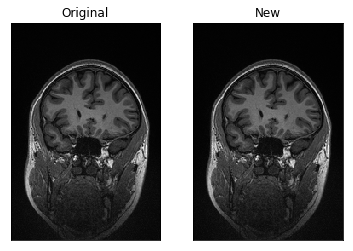

In [37]:
mri1 = mri(img)
ks = mri1.ks
new_3d_ks = ks.copy()

new_3d_vs = mri1.fft_back(new_3d_ks)

mri1.show_slice(np.abs(new_3d_vs[100]), 100, 'v')

# testing_3d = ndimage.rotate(new_3d_ks.real, rot, reshape = False)

# steps-
# transform to kspace

# rotate&translate 3d kspace
# get one slice of that modified kspace

# replace rotated slice into original kspace

In [38]:
motion1 = motion('motion1.dat')
mod_k, mod_v = mri1.create_mod_slices(motion1)
        
    

KeyboardInterrupt: 

(Text(0.5,1,'K-space'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

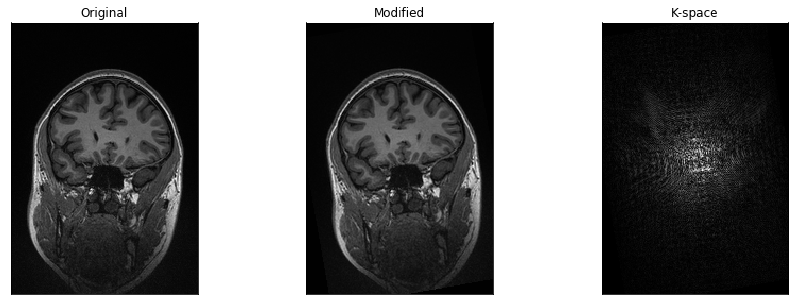

In [6]:
# testing out mod_kspace_slice
# trans = [0,30,0]
trans = None
rot = 10
slice_num = 100
rot_axes = (1,2)
modded_k, modded_v = mri1.mod_kspace_slice(trans,rot,rot_axes,slice_num)
modded_k_vis = np.abs(modded_k)
plt.figure(figsize= (15,5))
plt.subplot(131), plt.imshow(img[slice_num], cmap='gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(modded_v, cmap='gray')
plt.title('Modified'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(modded_k_vis, cmap='gray')
plt.title('K-space'), plt.xticks([]), plt.yticks([])